# Milestone 3 : Predicting the next summer hit !
__Write random BS about the project__

## Must have

- Extract and match billboard rankings __Parsing_test__
- Extract artist tags and  __DONE in tags__
- Extract popular pitches
- Find language based on lyrics (words)
- Most frequent words
- Artist coords (if relevent)

- Find relation between the songs/success/features by year 
- ML on the features

- Do da report

## Nice to have 
- Sentiment analysis on lyrics and find keywords for summer hit
- Match sentiment with song feature (Sad lyrics == minor mode ? )


In [2]:
import src.graphing_functions as graphing_functions
import pickle

In [3]:
%load_ext autoreload
%autoreload 2

# Test space

In [ ]:
import sys
sys.path.append(r'/home/marc/bin/spark/spark-1.6.3-bin-hadoop2.6/python/lib/py4j-0.9-src.zip')
sys.path.append(r'/home/marc/bin/spark/spark-1.6.3-bin-hadoop2.6/python/lib/pyspark.zip')

In [12]:
import os
os.environ['SPARK_HOME'] = r"/home/marc/bin/spark/spark-1.6.3-bin-hadoop2.6"

In [10]:
from pyspark import SparkContext

In [25]:
import numpy as np

In [13]:
sc = SparkContext()
DATA_DIR = 'data/'
music_brainz_rdd = sc.pickleFile(DATA_DIR + 'musicbrainz-songs')
analysis_songs_rdd = sc.pickleFile(DATA_DIR + 'analysis-songs')
metadata_songs_rdd = sc.pickleFile(DATA_DIR + 'metadata-songs')

In [17]:
import src.analysis_functions as analysis_functions

In [36]:
year = music_brainz_rdd.map(lambda x: x[1]['year'][0]).filter(lambda x: analysis_functions.is_numeric(x))\
    .distinct().collect()

In [37]:
year

[0,
 1984,
 1936,
 1956,
 2008,
 2004,
 1960,
 1996,
 1964,
 1988,
 1968,
 1992,
 1940,
 2000,
 1976,
 1972,
 1980,
 1985,
 1953,
 1957,
 2001,
 1929,
 1965,
 1997,
 1969,
 1993,
 1973,
 1961,
 1977,
 2005,
 2009,
 1981,
 1989,
 1934,
 1950,
 1986,
 2006,
 1926,
 1958,
 1930,
 1994,
 2002,
 1966,
 1962,
 1970,
 1998,
 1974,
 1990,
 1978,
 2010,
 1982,
 1954,
 1979,
 1935,
 1999,
 1959,
 1963,
 1995,
 1967,
 2007,
 1971,
 1927,
 1991,
 1975,
 2003,
 1947,
 1955,
 1987,
 1983]

In [44]:
danceability = analysis_songs_rdd.map(lambda x: x[1]['key'][0]).filter(lambda x: analysis_functions.is_numeric(x))

In [45]:
a

[0, 8, 4, 1, 5, 9, 2, 10, 6, 11, 3, 7]

# First Step: analysis of the data

Before doing any step on the data, we need to understand the data we are dealing with. There are different ways of doing. In our case, we are going to print the histograms of the features we are interested in. The histograms will give us a quick an intuitive way of seeing the distribution of the values

### Histograms of data

In [4]:
def load_histogram_results(path, filename):
    """
    simple utility function to load the histogram pickle files
    """
    with open(path + filename) as in_file:
        data = pickle.load(in_file)
    return data

First we load the global histograms of the main features we are interested in:

In [5]:
histogram_folder = 'cluster_out/histograms/'
histogram_global = {
    'danceability': load_histogram_results(histogram_folder, 'danceability-global'),
    'duration': load_histogram_results(histogram_folder, 'duration-global'),
    'energy': load_histogram_results(histogram_folder, 'energy-global'),
    'hotness': load_histogram_results(histogram_folder, 'hotness-global'),
    'key': load_histogram_results(histogram_folder, 'key-global'),
    'latitude': load_histogram_results(histogram_folder, 'latitude-global'),
    'longitude': load_histogram_results(histogram_folder, 'longitude-global'),
    'loudness': load_histogram_results(histogram_folder, 'loudness-global'),
    'tempo': load_histogram_results(histogram_folder, 'tempo-global'),
    'time_signature': load_histogram_results(histogram_folder, 'time_signature-global'),
    'year': load_histogram_results(histogram_folder, 'year-global')
}

We now check which histograms are empty. This can happen if either all values are 0, or none of it's elements are numeric values.

In [6]:
for key in histogram_global.keys():
    if histogram_global[key] == (None, None, None):
        print("{0} is an empty histogram".format(key))

energy is an empty histogram
key is an empty histogram
year is an empty histogram
danceability is an empty histogram
time_signature is an empty histogram


We can now print all non empty histograms:

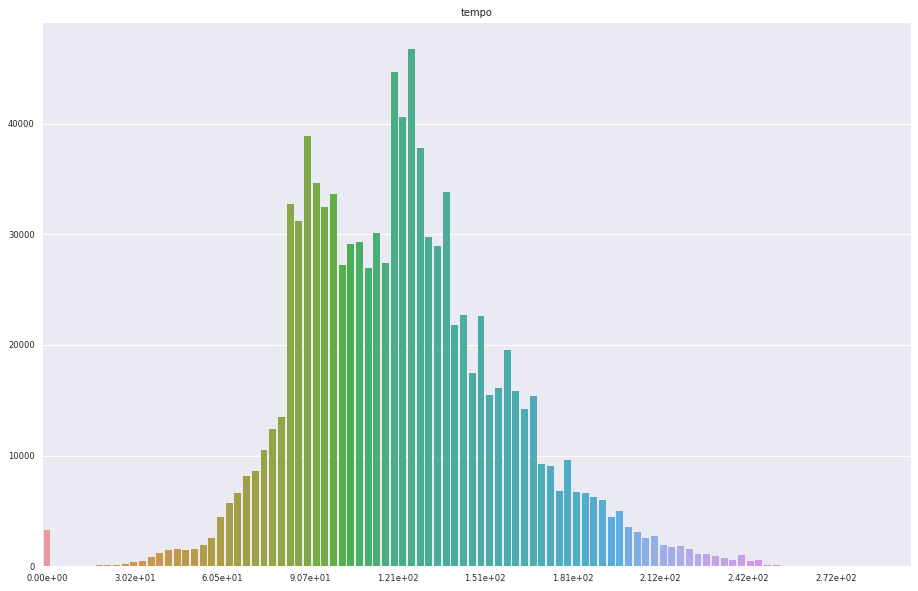

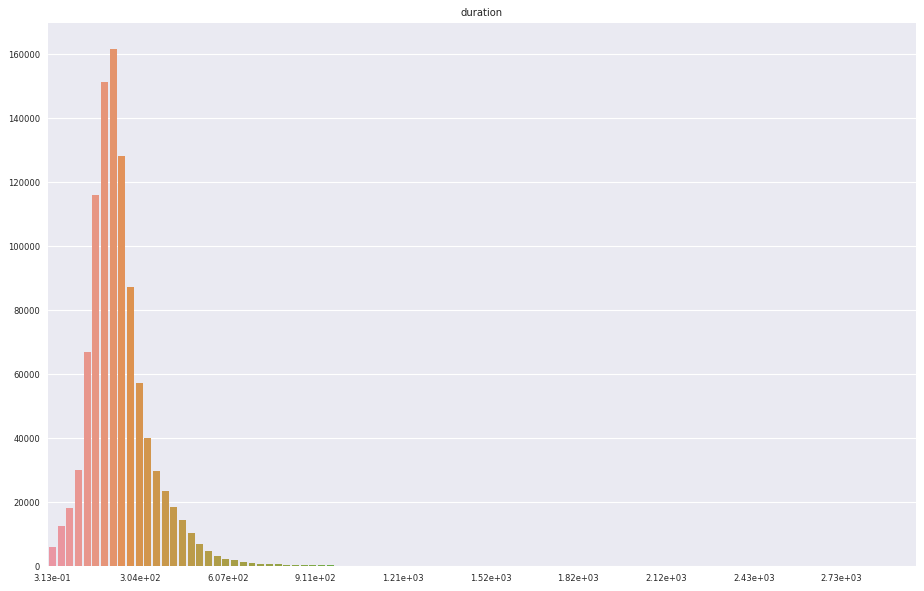

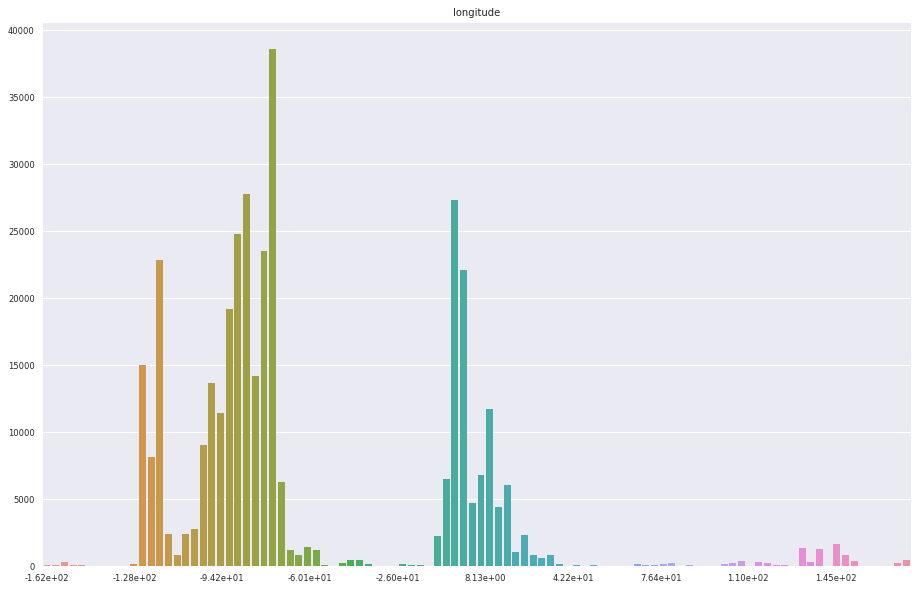

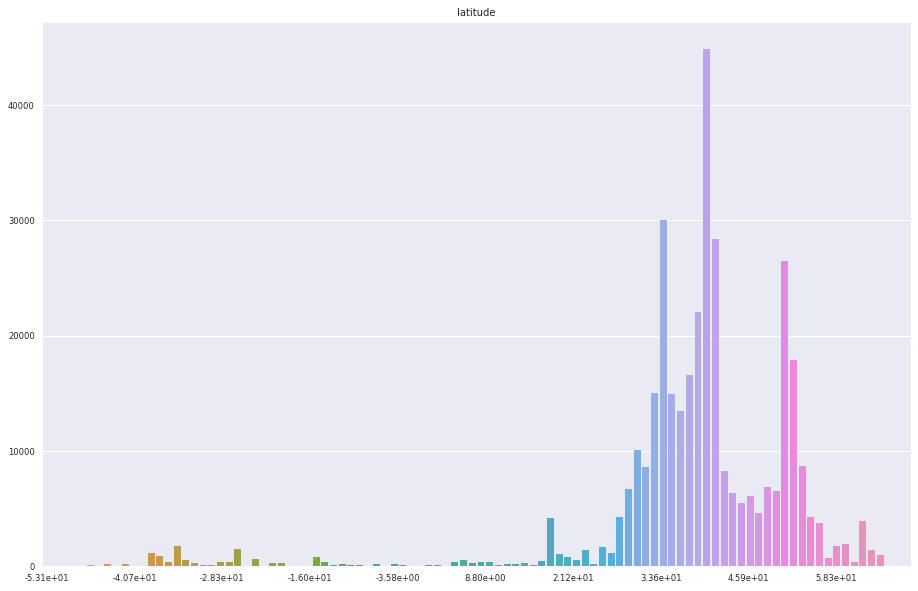

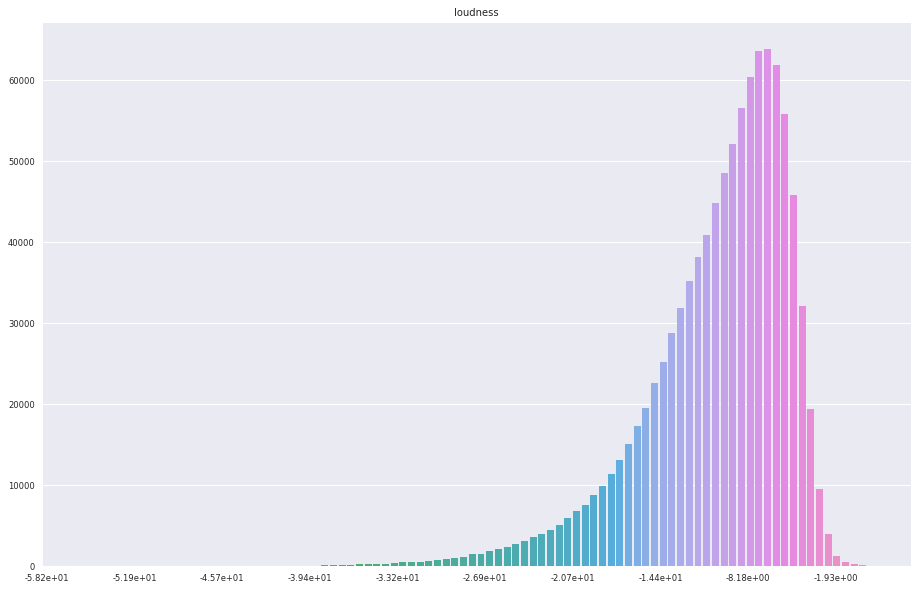

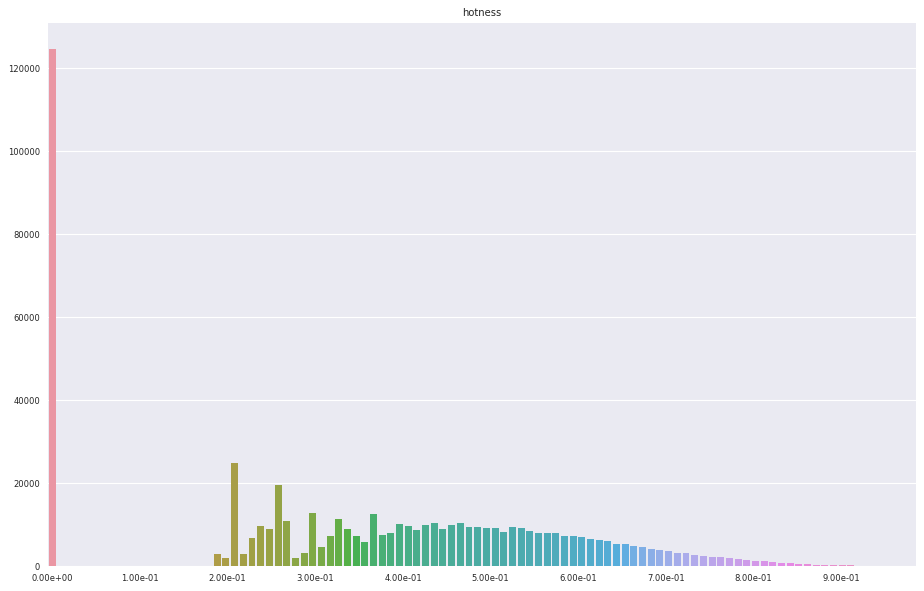

In [8]:
for key in histogram_global.keys():
    if histogram_global[key] != (None, None, None):
        graphing_functions.print_histogram(histogram_global[key][2], title=key, figsize=(14, 9))